# <center>**Board Game Recommender**</center>

<img src='Board_Game.png'>

## **Table of Contents (Work in progress)**

1. [Problem Statement](#problem)
2. [Data Loading and Review](#data-loading)
3. [Exploratory Data Analysis (EDA)](#eda)
4. [Data Preprocessing](#data-preprocess)
[<ul>4.1 Custom Transformer</ul>](#custom)
[<ul>4.2 Numerical Pipelines</ul>](#numeric)
[<ul>4.3 Ordinal Pipeline</ul>](#ordinal)
[<ul>4.4 Column Transformers</ul>](#column)
5. [Model Selection and Training](#selection)
[<ul>5.1 Shortlist Promising Models</ul>](#initial)
[<ul>5.2 Fine Tuning</ul>](#fine)
6. [Model Evaluation](#evaluation)
7. [Conclusion](#conclude)
8. [Appendix](#append)

---

## **1. Problem Statement** <a class="anchor" id="problem"></a>

The goal of this project is to create a model to recommend board games using the [Board Games Dataset](https://www.kaggle.com/datasets/andrewmvd/board-games) from Kaggle.  This project was created as the capstone project in my Master of Data Science program at Eastern University.  

The dataset author's description of the columns is in the Appendix section.  

## **2. Data Loading and Exploration** <a class="anchor" id="data-loading"></a>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
%%html
<style>
table {
  float: left;
}
</style>

In [4]:
board_game_data = pd.read_csv("bgg_dataset.csv")

In [5]:
board_game_data.head()

,ID,Name,Year Published,Min Players,Max Players,Play Time,Min Age,Users Rated,Rating Average,BGG Rank,Complexity Average,Owned Users,Mechanics,Domains
0,174430.0,Gloomhaven,2017.0,1,4,120,14,42055,8.79,1,3.86,68323.0,"Action Queue, Action Retrieval, Campaign / Bat...","Strategy Games, Thematic Games"
1,161936.0,Pandemic Legacy: Season 1,2015.0,2,4,60,13,41643,8.61,2,2.84,65294.0,"Action Points, Cooperative Game, Hand Manageme...","Strategy Games, Thematic Games"
2,224517.0,Brass: Birmingham,2018.0,2,4,120,14,19217,8.66,3,3.91,28785.0,"Hand Management, Income, Loans, Market, Networ...",Strategy Games
3,167791.0,Terraforming Mars,2016.0,1,5,120,12,64864,8.43,4,3.24,87099.0,"Card Drafting, Drafting, End Game Bonuses, Han...",Strategy Games
4,233078.0,Twilight Imperium: Fourth Edition,2017.0,3,6,480,14,13468,8.70,5,4.22,16831.0,"Action Drafting, Area Majority / Influence, Ar...","Strategy Games, Thematic Games"


In [6]:
board_game_data.duplicated().sum()

0

There are no duplicated rows in the data.

In [7]:
board_game_data.shape

(20343, 14)

There are a little over 20,000 games in the data, which should be more than enough to make a recommendation engine.  

In [8]:
board_game_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20343 entries, 0 to 20342
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  20327 non-null  float64
 1   Name                20343 non-null  object 
 2   Year Published      20342 non-null  float64
 3   Min Players         20343 non-null  int64  
 4   Max Players         20343 non-null  int64  
 5   Play Time           20343 non-null  int64  
 6   Min Age             20343 non-null  int64  
 7   Users Rated         20343 non-null  int64  
 8   Rating Average      20343 non-null  float64
 9   BGG Rank            20343 non-null  int64  
 10  Complexity Average  20343 non-null  float64
 11  Owned Users         20320 non-null  float64
 12  Mechanics           18745 non-null  object 
 13  Domains             10184 non-null  object 
dtypes: float64(5), int64(6), object(3)
memory usage: 2.2+ MB


In [9]:
board_game_data.isna().sum()

ID                       16
Name                      0
Year Published            1
Min Players               0
Max Players               0
Play Time                 0
Min Age                   0
Users Rated               0
Rating Average            0
BGG Rank                  0
Complexity Average        0
Owned Users              23
Mechanics              1598
Domains               10159
dtype: int64

There are 16 ID's, 23 Owned Users, and 1 year published missing.  That is not as big of a deal as the 1,500 missing mechanics or 10,000 missing domains.  Domains (such as Strategy Game, etc.) are not going to be that important, so that column will likely be removed in the final data, but the mechanics column could be important.  These entries will not be removed from the data, but they will have to be filled in with something for the model to work.  

In [10]:
board_game_data[board_game_data['ID'].isna()]

,ID,Name,Year Published,Min Players,Max Players,Play Time,Min Age,Users Rated,Rating Average,BGG Rank,Complexity Average,Owned Users,Mechanics,Domains
10776,NaN,Ace of Aces: Jet Eagles,1990.0,2,2,20,10,110,6.26,10778,2.00,NaN,NaN,NaN
10835,NaN,Die Erben von Hoax,1999.0,3,8,45,12,137,6.05,10837,2.00,NaN,NaN,NaN
11152,NaN,Rommel in North Africa: The War in the Desert ...,1986.0,2,2,0,12,53,6.76,11154,4.00,NaN,NaN,NaN
11669,NaN,Migration: A Story of Generations,2012.0,2,4,30,12,49,7.20,11671,2.00,NaN,NaN,NaN
12649,NaN,Die Insel der steinernen Wachter,2009.0,2,4,120,12,49,6.73,12651,3.00,NaN,NaN,NaN
12764,NaN,Dragon Ball Z TCG (2014 edition),2014.0,2,2,20,8,33,7.03,12766,2.50,NaN,NaN,NaN
13282,NaN,Dwarfest,2014.0,2,6,45,12,82,6.13,13284,1.75,NaN,NaN,NaN
13984,NaN,Hus,NaN,2,2,40,0,38,6.28,13986,2.00,NaN,NaN,NaN
14053,NaN,Contrario 2,2006.0,2,12,0,14,37,6.30,14055,1.00,NaN,NaN,NaN
14663,NaN,Warage: Extended Edition,2017.0,2,6,90,10,49,7.64,14665,3.00,NaN,NaN,NaN


In [11]:
board_game_data[board_game_data['Year Published'].isna()]

,ID,Name,Year Published,Min Players,Max Players,Play Time,Min Age,Users Rated,Rating Average,BGG Rank,Complexity Average,Owned Users,Mechanics,Domains
13984,NaN,Hus,NaN,2,2,40,0,38,6.28,13986,2.0,NaN,NaN,NaN


In [12]:
board_game_data[board_game_data['Owned Users'].isna()]

,ID,Name,Year Published,Min Players,Max Players,Play Time,Min Age,Users Rated,Rating Average,BGG Rank,Complexity Average,Owned Users,Mechanics,Domains
2828,202755.0,Guildhall Fantasy: Fellowship,2016.0,2,4,45,10,565,7.13,2830,2.00,NaN,"Hand Management, Take That, Set Collection",NaN
3590,196305.0,Guildhall Fantasy: Alliance,2016.0,2,4,45,10,360,7.20,3592,2.14,NaN,"Hand Management, Set Collection, Take That",NaN
3739,196306.0,Guildhall Fantasy: Coalition,2016.0,2,4,45,10,336,7.19,3741,2.13,NaN,"Hand Management, Set Collection, Take That",NaN
5807,289.0,Chariot Lords,1999.0,3,4,360,12,221,6.68,5809,3.00,NaN,"Area Movement, Variable Player Powers",NaN
9202,6813.0,Operation Market Garden: Descent into Hell,1985.0,2,2,120,12,94,6.72,9204,3.00,NaN,"Dice Rolling, Events, Grid Movement, Hexagon G...",NaN
9317,139.0,Hoax,1981.0,3,12,45,10,216,5.97,9319,1.38,NaN,"Deduction, Hidden Roles, Voting",NaN
10075,266756.0,Devil Boats: PT Boats in the Solomons,2021.0,1,1,60,14,49,7.84,10077,2.83,NaN,NaN,NaN
10776,NaN,Ace of Aces: Jet Eagles,1990.0,2,2,20,10,110,6.26,10778,2.00,NaN,NaN,NaN
10835,NaN,Die Erben von Hoax,1999.0,3,8,45,12,137,6.05,10837,2.00,NaN,NaN,NaN
11152,NaN,Rommel in North Africa: The War in the Desert ...,1986.0,2,2,0,12,53,6.76,11154,4.00,NaN,NaN,NaN


## **3. Exploratory Data Analysis (EDA)** <a class="anchor" id="eda"></a>

In [13]:
board_game_data[['Min Players', 'Max Players', 'Play Time', 'Min Age', 'Users Rated', 'Rating Average', 
                 'Complexity Average', 'Owned Users']].describe()


,Min Players,Max Players,Play Time,Min Age,Users Rated,Rating Average,Complexity Average,Owned Users
count,20343.000000,20343.000000,20343.000000,20343.000000,20343.000000,20343.000000,20343.000000,20320.000000
mean,2.019712,5.672221,91.294548,9.601485,840.971391,6.403227,1.991188,1408.457628
std,0.690366,15.231376,545.447203,3.645458,3511.562220,0.935911,0.848903,5040.179315
min,0.000000,0.000000,0.000000,0.000000,30.000000,1.050000,0.000000,0.000000
25%,2.000000,4.000000,30.000000,8.000000,55.000000,5.820000,1.330000,146.000000
50%,2.000000,4.000000,45.000000,10.000000,120.000000,6.430000,1.970000,309.000000
75%,2.000000,6.000000,90.000000,12.000000,385.000000,7.030000,2.540000,864.000000
max,10.000000,999.000000,60000.000000,25.000000,102214.000000,9.580000,5.000000,155312.000000


Several things stand out from this summary above:

  1. The mean number of minimum players is 2, and the max is 10.  There must be some very large games in the data, and 
    that should be ok to leave as is.   
  2. The minimum of minimum age is 0, which needs to be investigated further.  Is that an error or just meaning anyone can play the game?  Same question for minimum play time.
  3.  The mean max players is around 6, but the maximum is 999.  Those are very large games, and it is unlikely many games   have that requirement.  Those games should be looked at and possibly removed or capped.  Alternatively, this column could be scaled to accommodate this large difference in maximum player counts.   
  4.  The mean play time is 90 minutes, but the maximum is 60,000 mins (1000 hours or 41 days)!  That is a huge 
    difference, and once again will need capped or scaled in the final model.  
  5.  The minimum of complexity average is 0 even if the scale is from 1 - 5.  That must be an error that needs to be corrected in the final data.
 


C:\Users\ejb51\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 0, 'Minimum Age')

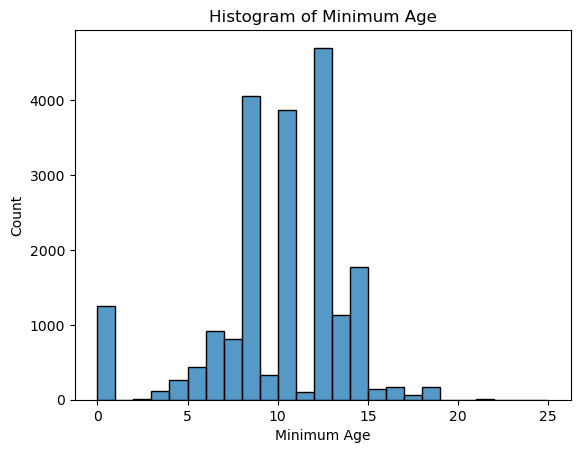

In [25]:
sns.histplot(board_game_data, x='Min Age', binwidth=1)
plt.title('Histogram of Minimum Age')
plt.xlabel('Minimum Age')

The majority of the games fall between the 8 to 14 age range, which makes sense for modern games.

C:\Users\ejb51\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Histogram of Rating Average')

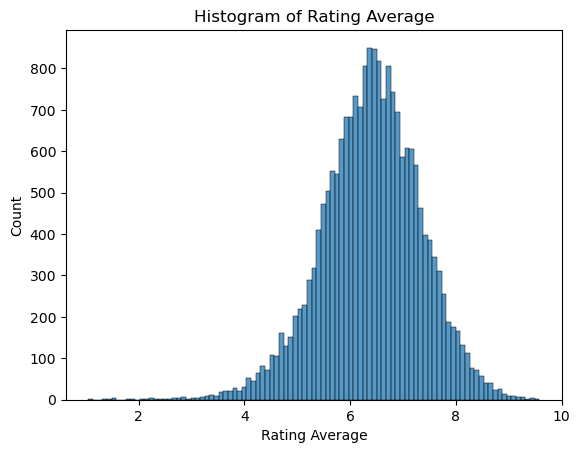

In [26]:
sns.histplot(board_game_data, x='Rating Average')
plt.title('Histogram of Rating Average')

The rating average is normally distributed with a mean of around 6.5.

C:\Users\ejb51\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Histogram of Play Time')

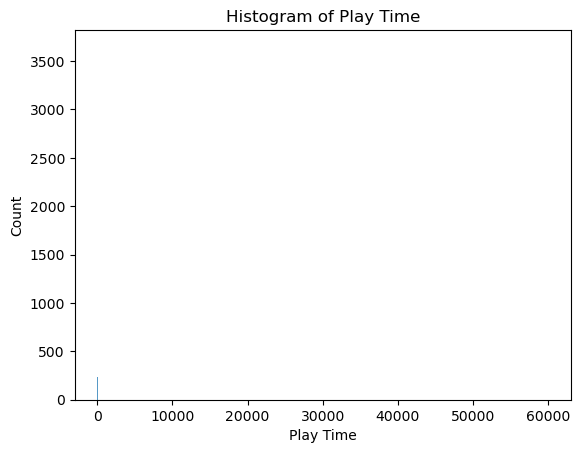

In [27]:
sns.histplot(board_game_data, x='Play Time')
plt.title('Histogram of Play Time')

As expected, the 60000 minute outlier drastically skewed the histogram of play time.  Theat needs to be investigated and removed to see the shape of the rest of the data.

In [36]:
board_game_data.sort_values(by='Play Time', ascending=False).head(200)

,ID,Name,Year Published,Min Players,Max Players,Play Time,Min Age,Users Rated,Rating Average,BGG Rank,Complexity Average,Owned Users,Mechanics,Domains
13420,4815.0,The Campaign for North Africa: The Desert War ...,1979.0,8,10,60000,14,146,6.10,13422,4.71,385.0,"Dice Rolling, Hexagon Grid, Simulation",Wargames
3208,29285.0,Case Blue,2007.0,2,2,22500,12,289,8.26,3210,4.58,711.0,"Dice Rolling, Hexagon Grid, Simulation",Wargames
6035,46669.0,1914: Offensive à outrance,2013.0,2,4,17280,0,108,7.98,6037,4.07,661.0,"Dice Rolling, Hexagon Grid, Simulation",Wargames
7895,158793.0,Atlantic Wall: D-Day to Falaise,2014.0,2,6,14400,16,69,8.08,7897,4.89,328.0,"Hexagon Grid, Zone of Control",Wargames
9497,6942.0,Drang Nach Osten!,1973.0,2,4,12000,12,77,6.82,9499,4.22,192.0,"Dice Rolling, Hexagon Grid, Simulation",Wargames
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8133,188124.0,Ostroleka 26 maja 1831,2015.0,2,4,600,16,82,8.95,8135,4.18,103.0,"Dice Rolling, Hexagon Grid, Variable Phase Order",Wargames
2397,125977.0,Cataclysm: A Second World War,2018.0,2,5,600,14,554,7.66,2399,3.85,1568.0,"Area Majority / Influence, Area Movement, Chit...",Wargames
12165,16169.0,Gettysburg: High Tide of the Confederacy,1982.0,2,8,600,12,33,7.23,12167,3.29,134.0,"Dice Rolling, Grid Movement, Hexagon Grid, Lin...",Wargames
6910,190462.0,Triumph of Chaos v.2 (Deluxe Edition),2019.0,2,2,600,16,74,8.32,6912,4.93,337.0,"Campaign / Battle Card Driven, Dice Rolling, M...",Wargames


There are at least 200 games with a play time of 600 minutes (6 hours) or higher.  The data will be filtered to remove entries above 600 just to see the shape of the rest of the data. 

C:\Users\ejb51\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Histogram of Play Time (<= 600 minutes)')

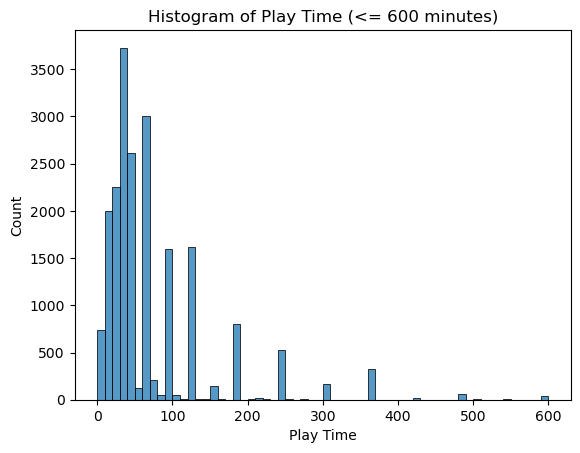

In [42]:
hist_data_under_600 = board_game_data[board_game_data['Play Time'] <= 600]
sns.histplot(hist_data_under_600, x='Play Time', binwidth=10)
plt.title('Histogram of Play Time (<= 600 minutes)')

After removing the high outliers, it appears that most games fall between 50 to 80 minutes, which is a reasonable play time for most games.

C:\Users\ejb51\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 0, 'Minimum Players')

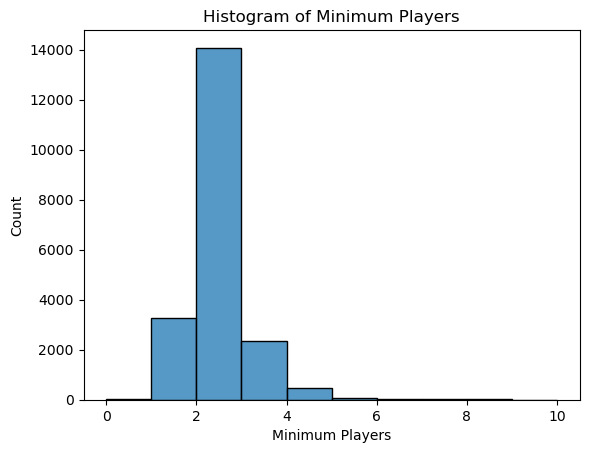

In [44]:
sns.histplot(board_game_data, x='Min Players', binwidth=1)
plt.title('Histogram of Minimum Players')
plt.xlabel('Minimum Players')

The majority of games require at least 2 players to play.  

C:\Users\ejb51\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Max Players', ylabel='Count'>

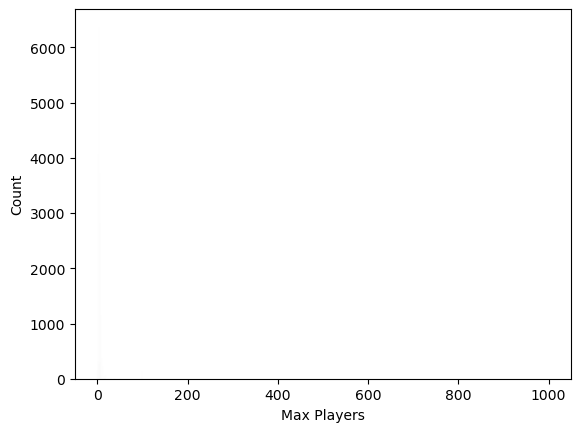

In [19]:
sns.histplot(board_game_data, x='Max Players')

As expected, the 999 player outlier skewed the distribution for the maximum number of players.  That needs to be reviewed further.  

In [51]:
board_game_data.sort_values(by='Max Players', ascending=False).head(200)

,ID,Name,Year Published,Min Players,Max Players,Play Time,Min Age,Users Rated,Rating Average,BGG Rank,Complexity Average,Owned Users,Mechanics,Domains
10813,189890.0,Scrimish Card Game,2015.0,2,999,100,8,254,5.90,10815,1.13,898.0,Memory,NaN
8516,28567.0,"I Don't Know, What Do You Want to Play?",2007.0,2,999,5,8,87,6.76,8518,1.06,117.0,Voting,NaN
7025,24996.0,Start Player: A Kinda Collectible Card Game,2006.0,2,999,1,6,178,6.49,7027,1.00,286.0,NaN,"Family Games, Party Games"
18781,3867.0,The Hammer of Thor: The Game of Norse Mythology,1980.0,1,362,120,12,60,4.95,18783,3.50,179.0,"Dice Rolling, Events, Paper-and-Pencil, Role P...",NaN
4913,147194.0,Linkee!,2012.0,2,200,30,14,523,6.33,4915,1.17,1225.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12818,191292.0,Mafia the Party Game,2014.0,7,36,20,8,40,6.89,12820,2.00,131.0,NaN,NaN
15408,40853.0,Trivial Pursuit: Genus VI,2006.0,2,36,240,15,134,5.64,15410,2.17,295.0,Roll / Spin and Move,NaN
5708,67148.0,Ultimate Werewolf: Compact Edition,2010.0,5,34,45,8,214,6.75,5710,1.44,410.0,"Role Playing, Team-Based Game, Traitor Game, V...",NaN
6091,59335.0,Wherewolf,2009.0,6,33,60,15,143,7.34,6093,1.93,243.0,"Acting, Player Elimination, Team-Based Game, V...",Party Games


In [20]:
board_game_data['Domains'].value_counts()

Domains
Wargames                                          3029
Strategy Games                                    1455
Family Games                                      1340
Abstract Games                                     869
Children's Games                                   708
Thematic Games                                     647
Party Games                                        409
Family Games, Strategy Games                       354
Customizable Games                                 235
Strategy Games, Thematic Games                     217
Thematic Games, Wargames                           139
Family Games, Party Games                          139
Abstract Games, Family Games                       116
Family Games, Thematic Games                       109
Children's Games, Family Games                     105
Strategy Games, Wargames                            99
Abstract Games, Strategy Games                      40
Party Games, Thematic Games                         36
Cu

In [21]:
board_game_data['Mechanics'].value_counts()

Mechanics
Hand Management                                                                                                 432
Hexagon Grid                                                                                                    412
Dice Rolling                                                                                                    372
Roll / Spin and Move                                                                                            369
Tile Placement                                                                                                  285
                                                                                                               ... 
Dice Rolling, Measurement Movement, Pick-up and Deliver, Variable Player Powers, Variable Set-up                  1
Action Points, Dice Rolling, Grid Movement, Modular Board, Variable Phase Order, Variable Player Powers           1
Area Movement, Hidden Movement, Secret Unit Deployment, Team-B

<Axes: xlabel='Rating Average', ylabel='Complexity Average'>

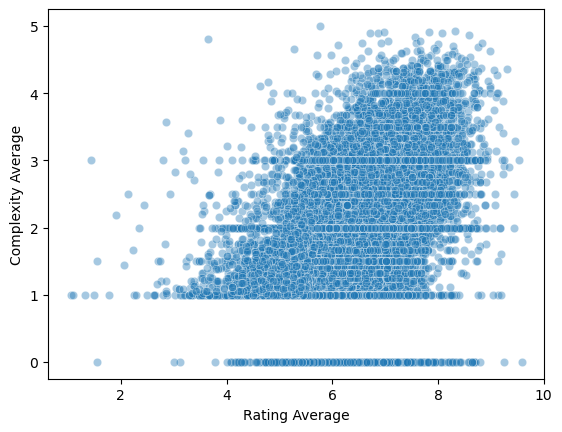

In [22]:
sns.scatterplot(board_game_data, x='Rating Average', y='Complexity Average', alpha=0.4)

## **4. Data Preprocessing** <a class="anchor" id="data-preprocess"></a>

## **5. Model Selection and Training** <a class="anchor" id="selection"></a>

### 5.1 Shortlist Promising Models <a class="anchor" id="initial"></a>

### 5.2 Fine Tuning<a class="anchor" id="fine"></a>

## **6. Model Evaluation** <a class="anchor" id="evaluation"></a>

## **7. Conclusion** <a class="anchor" id="conclude"></a>

## **8. Appendix** <a class="anchor" id="append"></a>

The description of the columns from the dataset author's Kaggle post are listed below:

|variable                 |class     |description |
|:---|:---|:-------|
|ID                       |int       | BoardGameGeek ID Number |
|Name                     |character | Board game name  |
|Year Published           |int       | Year published  |
|Min Players              |int       | The minimum suggested number of players to play the game |
|Max Players              |int       | The maximum suggested number of players to play the game |
|Play Time                |int       | Average play time in minutes as suggested by the game creators |
|Min Age                  |int       | Age rating |
|Users Rated              |int       | Number of users who rated the game |
|Rating Average           |float64   | Average of user ratings |
|BGG Rank                 |int       | BoardGameGeek ranking |
|Complexity Average       |float64   | Average of user ratings for complexity from 1 - 5 |
|Owned Users              |int       | Number of users who own the game |
|Mechanics                |character | List of game mechanics for that game |
|Domains                  |character | List of game subgenres |